# **Project : Employee Sentiment Analysis**

Name: Shaidatullisa Nadia Binti Saipudin



## Introduction

This project focuses on understanding how employees feel based on the messages they send (like emails or internal communications). The goal is to find out which employees are happy, frustrated, or neutral in their communication, and how their mood changes over time.

The process is divided into 6 tasks:

*   Label each message with a sentiment (Positive, Negative, Neutral).
*   Explore the data to find patterns and problems
* Calculate how employees feel each month.
* Rank the happiest and most upset employees.
* Spot employees who may be at risk of quitting.
* Build a model that predicts how sentiment might change

In [1]:
# Install dependencies (first time only)
#!pip install -q transformers textblob

# Required Libraries
import pandas as pd
from transformers import pipeline
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### **Task 1: Sentiment Labeling**

**Approach Used:**

* Combined **keyword-based rules**, a **pretrained LLM (RoBERTa)**, and **TextBlob** for more accurate and consistent sentiment labeling.
* Merged the email subject and body into a single text input for analysis.

**Steps Taken:**

* Applied **custom keyword lists** to catch common positive/negative phrases in employee emails.
* Used **RoBERTa** from Hugging Face (`cardiffnlp/twitter-roberta-base-sentiment`) to understand the tone and context.
* Added a **confidence threshold** (0.85) to accept only high-certainty predictions from RoBERTa.
* Used **TextBlob polarity** as a fallback if the model was unsure.

**Why This Works:**

* The keyword layer helps capture domain-specific tone quickly.
* RoBERTa provides deep contextual analysis.
* TextBlob ensures no messages are missed.
* The entire process is fully reproducible with the same script and open-source tools.

Let me know if you want this formatted for a README or final report.


In [2]:
# Load dataset
df = pd.read_csv("test.csv")
df["Subject"] = df["Subject"].fillna("")
df["body"] = df["body"].fillna("")
df["full_text"] = df["Subject"] + " " + df["body"]

# Load RoBERTa sentiment pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
roberta_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Keyword rules (tuned for employee communication)
positive_keywords = [
    "appreciate", "thanks", "thank you", "great job", "well done", "pleased", "awesome",
    "happy", "glad", "good work", "excellent", "fantastic", "love", "impressed",
    "smooth process", "resolved", "completed successfully"
]
negative_keywords = [
    "disappointed", "frustrated", "angry", "upset", "bad", "poor", "hate", "unhappy",
    "issue", "problem", "delay", "complaint", "concern", "dissatisfied", "did not work",
    "escalate", "unable to", "missed deadline", "error", "not working"
]

# Hybrid sentiment function
def hybrid_sentiment(text):
    text_lower = text.lower()

    # Keyword voting
    pos_hits = sum(1 for kw in positive_keywords if kw in text_lower)
    neg_hits = sum(1 for kw in negative_keywords if kw in text_lower)
    if pos_hits > neg_hits:
        return "Positive"
    elif neg_hits > pos_hits:
        return "Negative"

    # RoBERTa model prediction
    roberta_result = roberta_pipeline(text[:512])[0]  # truncate long text
    if roberta_result["score"] >= 0.85:  # confident
        if roberta_result["label"] == "LABEL_2":
            return "Positive"
        elif roberta_result["label"] == "LABEL_0":
            return "Negative"
        else:
            return "Neutral"

    # TextBlob fallback
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment labeling
df["Final_Sentiment"] = df["full_text"].apply(hybrid_sentiment)

# View result
df[["from", "date", "Subject", "Final_Sentiment"]].head(10)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cpu


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

,from,date,Subject,Final_Sentiment
0,sally.beck@enron.com,5/10/2010,EnronOptions Update!,Positive
1,eric.bass@enron.com,7/29/2010,(No Subject),Positive
2,sally.beck@enron.com,7/25/2011,Phone Screen Interview - Shannon L. Burnham,Neutral
3,johnny.palmer@enron.com,3/25/2010,RE: My new work email,Neutral
4,lydia.delgado@enron.com,5/21/2011,Bet,Neutral
5,eric.bass@enron.com,10/23/2011,RE: Favor,Positive
6,kayne.coulter@enron.com,4/5/2010,MG Inventory Summaries,Neutral
7,patti.thompson@enron.com,4/21/2010,Forgot the Attachment,Positive
8,sally.beck@enron.com,2/7/2010,Garvin Brown - AXIA Sr. Power Scheduler,Positive
9,kayne.coulter@enron.com,2/6/2010,More Dallas ASE Information,Positive


In [3]:
# Make a copy of the labeled DataFrame
df_labeled = df.copy()

# Save to CSV with a clear name
df_labeled.to_csv("employee_messages_labeled.csv", index=False)

### **Task 2: EDA Summary**

**What I did:**

* Merged and analyzed the labeled sentiment data (`Final_Sentiment`) from Task 1.
* Checked the dataset structure, missing values, and message volumes.
* Analyzed sentiment **distribution**, **monthly trends**, and **message length** by sentiment.
* Explored employee-level sentiment ratios and top senders with high negative rates.
* Created a **7-day rolling sentiment trend** to catch short-term stress or engagement drops.
* Compared **frequent keywords** in positive vs. negative messages.
* Built a **heatmap** to spot employees with consistent negativity across months.

---

**Why this matters:**

* These visual insights help identify **who is struggling**, **when morale dips**, and **what employees are talking about**.
* This forms a strong foundation for upcoming tasks like **employee scoring**, **ranking**, and **flight risk detection**.
* By understanding patterns and anomalies now, we can better target the predictive modeling and HR interventions later.



Dataset Structure Summary
            Column       Data Type  Missing Values  Unique Values
0          Subject          object               0           1251
1             body          object               0           1539
2             date  datetime64[ns]               0            690
3             from          object               0             10
4        full_text          object               0           1566
5  Final_Sentiment          object               0              3
6       year_month       period[M]               0             24
7              day          object               0            690
8            month       period[M]               0             24
9   message_length           int64               0            160


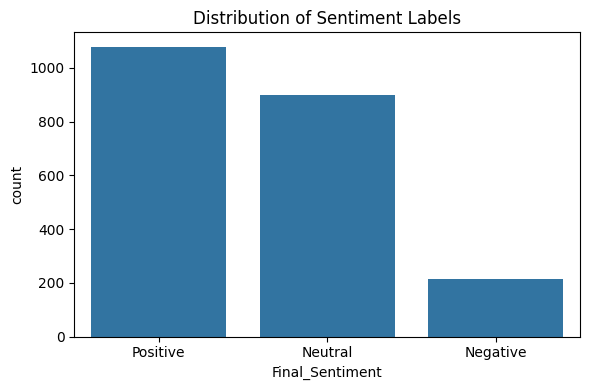

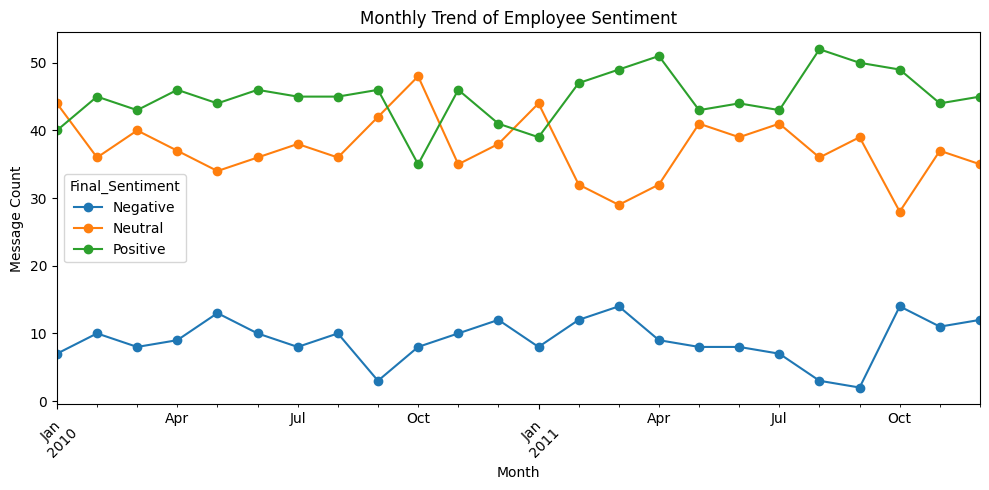

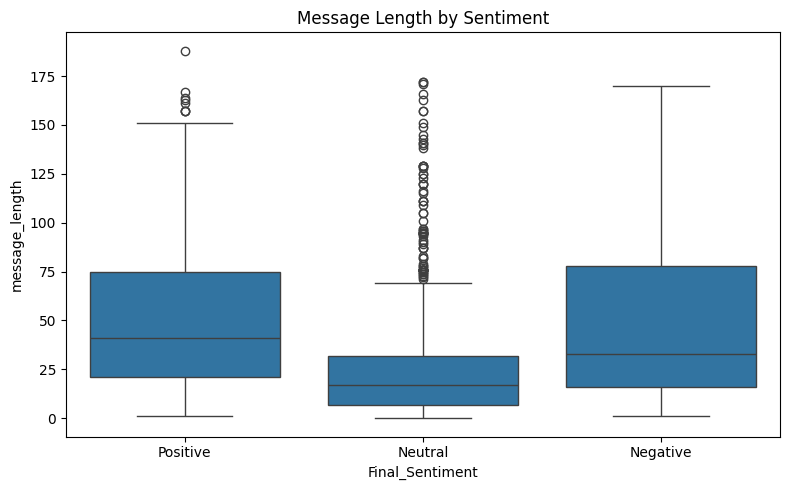

Sentiment Ratio per Employee
Final_Sentiment              Negative   Neutral  Positive  Total_Messages
from                                                                     
bobette.riner@ipgdirect.com  0.138249  0.437788  0.423963             217
john.arnold@enron.com        0.109375  0.429688  0.460938             256
lydia.delgado@enron.com      0.109155  0.401408  0.489437             284
patti.thompson@enron.com     0.106667  0.382222  0.511111             225
rhonda.denton@enron.com      0.098837  0.412791  0.488372             172
kayne.coulter@enron.com      0.097701  0.413793  0.488506             174
eric.bass@enron.com          0.090476  0.414286  0.495238             210
sally.beck@enron.com         0.088106  0.378855  0.533040             227
johnny.palmer@enron.com      0.075117  0.361502  0.563380             213
don.baughman@enron.com       0.065728  0.464789  0.469484             213


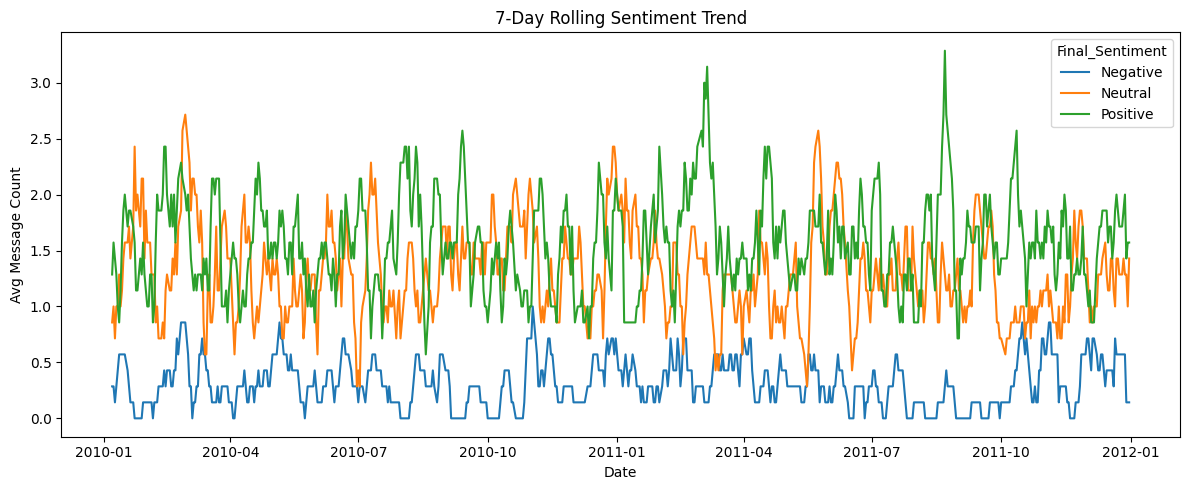

Top Senders by Volume and Negative Rate
                             Total_Messages  Negative_Messages  Negative_Rate
from                                                                         
lydia.delgado@enron.com                 284                 31       0.109155
john.arnold@enron.com                   256                 28       0.109375
sally.beck@enron.com                    227                 20       0.088106
patti.thompson@enron.com                225                 24       0.106667
bobette.riner@ipgdirect.com             217                 30       0.138249
don.baughman@enron.com                  213                 14       0.065728
johnny.palmer@enron.com                 213                 16       0.075117
eric.bass@enron.com                     210                 19       0.090476
kayne.coulter@enron.com                 174                 17       0.097701
rhonda.denton@enron.com                 172                 17       0.098837
Keyword Frequency by Sen

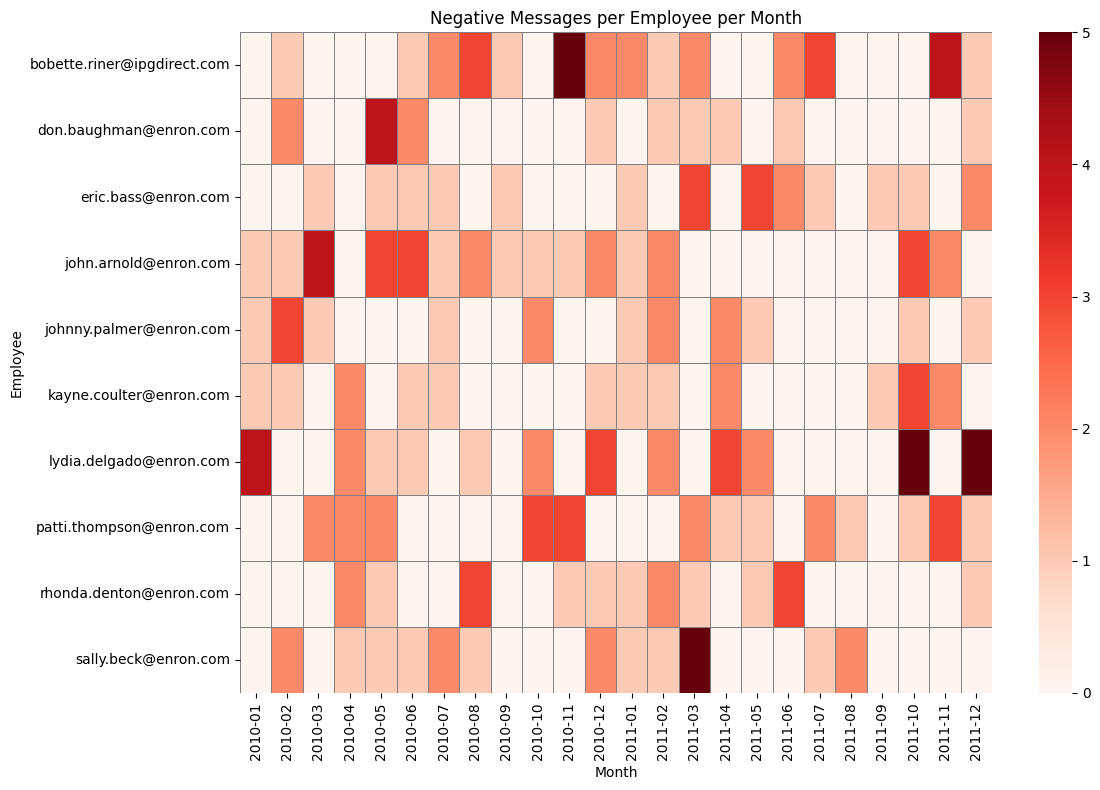

In [4]:
# Convert the 'date' column to datetime objects
df_labeled["date"] = pd.to_datetime(df_labeled["date"])

# Preprocessing
# Convert the 'date' column to datetime objects
df_labeled["date"] = pd.to_datetime(df_labeled["date"])
df_labeled["year_month"] = df_labeled["date"].dt.to_period("M")
df_labeled["day"] = df_labeled["date"].dt.date
df_labeled["month"] = df_labeled["date"].dt.to_period("M")
df_labeled["message_length"] = df_labeled["body"].apply(lambda x: len(str(x).split()))

# 1. Dataset Structure Summary
structure_summary = pd.DataFrame({
    "Column": df_labeled.columns,
    "Data Type": df_labeled.dtypes.values,
    "Missing Values": df_labeled.isnull().sum().values,
    "Unique Values": df_labeled.nunique().values
})
print("Dataset Structure Summary")
print(structure_summary)

# 2. Sentiment Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_labeled, x="Final_Sentiment", order=["Positive", "Neutral", "Negative"])
plt.title("Distribution of Sentiment Labels")
plt.tight_layout()
plt.show()

# 3. Monthly Sentiment Trends
monthly_trends = df_labeled.groupby(["year_month", "Final_Sentiment"]).size().unstack().fillna(0)
monthly_trends.plot(kind="line", marker="o", figsize=(10, 5))
plt.title("Monthly Trend of Employee Sentiment")
plt.xlabel("Month")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Message Length by Sentiment
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_labeled, x="Final_Sentiment", y="message_length", order=["Positive", "Neutral", "Negative"])
plt.title("Message Length by Sentiment")
plt.tight_layout()
plt.show()

# 5. Sentiment Ratio per Employee
sentiment_ratio = df_labeled.groupby("from")["Final_Sentiment"].value_counts(normalize=True).unstack().fillna(0)
sentiment_ratio["Total_Messages"] = df_labeled["from"].value_counts()
sentiment_ratio_sorted = sentiment_ratio.sort_values(by="Negative", ascending=False)
print("Sentiment Ratio per Employee")
print(sentiment_ratio_sorted.head(10))

# 6. Weekly Rolling Sentiment Trend
daily_trend = df_labeled.groupby(["day", "Final_Sentiment"]).size().unstack().fillna(0)
rolling_trend = daily_trend.rolling(window=7).mean()
rolling_trend.plot(figsize=(12, 5), title="7-Day Rolling Sentiment Trend")
plt.xlabel("Date")
plt.ylabel("Avg Message Count")
plt.tight_layout()
plt.show()

# 7. Top Senders by Volume and Negative Rate
sender_volume = df_labeled["from"].value_counts().rename("Total_Messages")
negative_count = df_labeled[df_labeled["Final_Sentiment"] == "Negative"]["from"].value_counts().rename("Negative_Messages")
top_senders = pd.concat([sender_volume, negative_count], axis=1).fillna(0)
top_senders["Negative_Rate"] = top_senders["Negative_Messages"] / top_senders["Total_Messages"]
top_senders_sorted = top_senders.sort_values(by="Total_Messages", ascending=False)
print("Top Senders by Volume and Negative Rate")
print(top_senders_sorted.head(10))

# 8. Keyword Frequency by Sentiment
positive_words = df_labeled[df_labeled["Final_Sentiment"] == "Positive"]["body"].dropna().str.lower()
negative_words = df_labeled[df_labeled["Final_Sentiment"] == "Negative"]["body"].dropna().str.lower()

vectorizer = CountVectorizer(stop_words='english', max_features=50)
pos_matrix = vectorizer.fit_transform(positive_words)
pos_keywords = pd.DataFrame(pos_matrix.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

vectorizer = CountVectorizer(stop_words='english', max_features=50)
neg_matrix = vectorizer.fit_transform(negative_words)
neg_keywords = pd.DataFrame(neg_matrix.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

keyword_comparison = pd.DataFrame({
    "Positive_Freq": pos_keywords,
    "Negative_Freq": neg_keywords
}).fillna(0).astype(int)
print("Keyword Frequency by Sentiment")
print(keyword_comparison.head(15))

# 9. Heatmap of Negative Messages (Employee × Month)
negatives = df_labeled[df_labeled["Final_Sentiment"] == "Negative"]
heatmap_data = negatives.groupby(["from", "month"]).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.5, linecolor="gray")
plt.title("Negative Messages per Employee per Month")
plt.xlabel("Month")
plt.ylabel("Employee")
plt.tight_layout()
plt.show()

### **Task 3: Employee Score Calculation**

**What I did:**

* Assigned each message a numeric score:

  * **+1** for Positive
  * **0** for Neutral
  * **–1** for Negative
* Grouped all messages by **employee** and **month**.
* Calculated the **total sentiment score** for each employee per month by summing the message scores.
* Saved the results in a new dataset called `monthly_employee_sentiment_scores.csv`.

---

**Why this matters:**

* The monthly score reflects an employee’s **sentiment trend over time**.
* Scores reset each month to ensure **accurate tracking** of engagement changes.
* This data forms the foundation for the next steps: **ranking top/bottom performers** and identifying **flight risks** based on prolonged negativity.



In [5]:
# Map sentiment labels to numeric scores
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df_labeled["sentiment_score"] = df_labeled["Final_Sentiment"].map(score_map)

# Group by employee and month, then sum the sentiment scores
monthly_employee_scores = df_labeled.groupby(["from", "month"])["sentiment_score"].sum().reset_index()

# Rename columns for clarity
monthly_employee_scores.rename(columns={
    "from": "employee",
    "month": "month",
    "sentiment_score": "monthly_sentiment_score"
}, inplace=True)

# Save to CSV file
monthly_employee_scores.to_csv("monthly_employee_sentiment_scores.csv", index=False)

# Preview the output
print("Monthly employee sentiment scores")
print(monthly_employee_scores.head(15))


Monthly employee sentiment scores
                       employee    month  monthly_sentiment_score
0   bobette.riner@ipgdirect.com  2010-01                        0
1   bobette.riner@ipgdirect.com  2010-02                        7
2   bobette.riner@ipgdirect.com  2010-03                        4
3   bobette.riner@ipgdirect.com  2010-04                        1
4   bobette.riner@ipgdirect.com  2010-05                        2
5   bobette.riner@ipgdirect.com  2010-06                        0
6   bobette.riner@ipgdirect.com  2010-07                        6
7   bobette.riner@ipgdirect.com  2010-08                       -1
8   bobette.riner@ipgdirect.com  2010-09                        5
9   bobette.riner@ipgdirect.com  2010-10                        3
10  bobette.riner@ipgdirect.com  2010-11                        2
11  bobette.riner@ipgdirect.com  2010-12                        1
12  bobette.riner@ipgdirect.com  2011-01                        6
13  bobette.riner@ipgdirect.com  2011-02  

### **Task 4: Employee Ranking**

**What I did:**

* Used the **monthly sentiment scores** from Task 3 to rank employees.
* Created **two separate lists** for each month:

  * **Top 3 Positive Employees** (highest scores)
  * **Top 3 Negative Employees** (lowest scores)
* Sorted results by **score (descending for positive, ascending for negative)**, and by **employee name** alphabetically to break ties.
* Saved the results in separate CSV files and also combined them into one for reporting.
* Visualized the rankings as **monthly bar charts**, with:

  * **Green bars** for positive sentiment
  * **Red bars** for negative sentiment

---

**Why this matters:**
These rankings give a clear view of employee sentiment performance each month. It helps HR or leadership easily identify who is consistently performing well (positive engagement) and who might need attention or support (repeated negative sentiment). The charts and sorted tables make it easy to review and report monthly performance trends.


<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


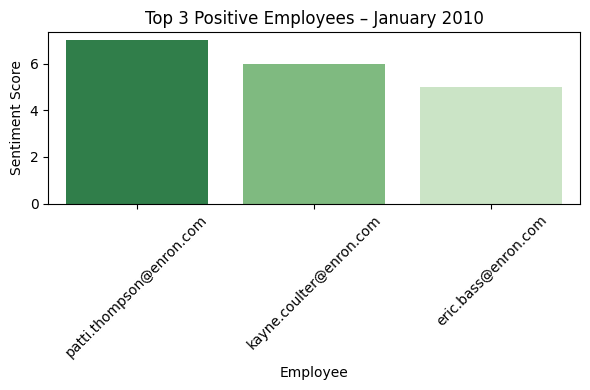

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


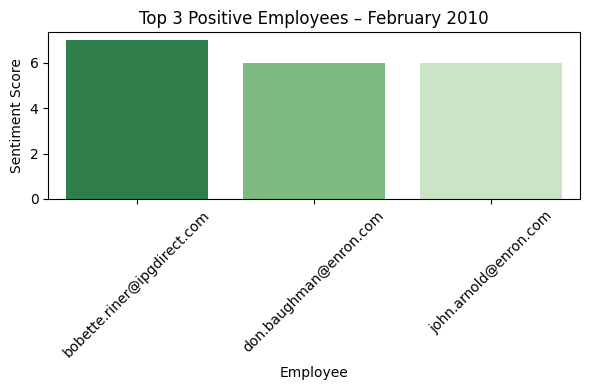

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


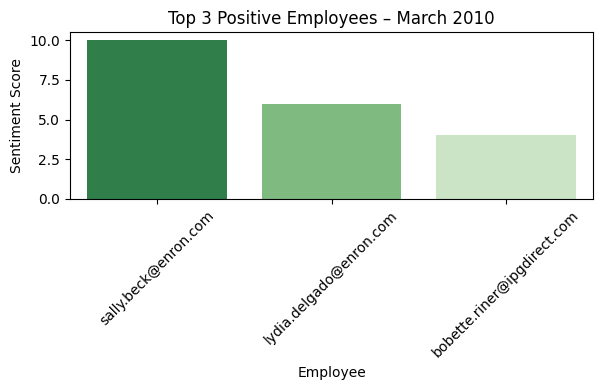

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


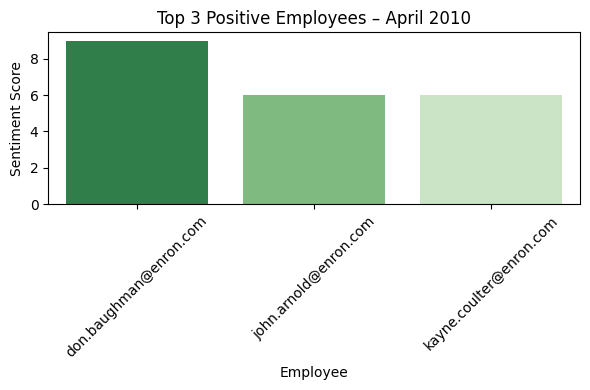

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


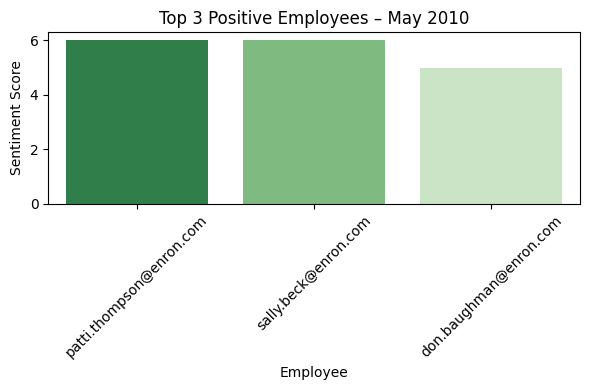

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


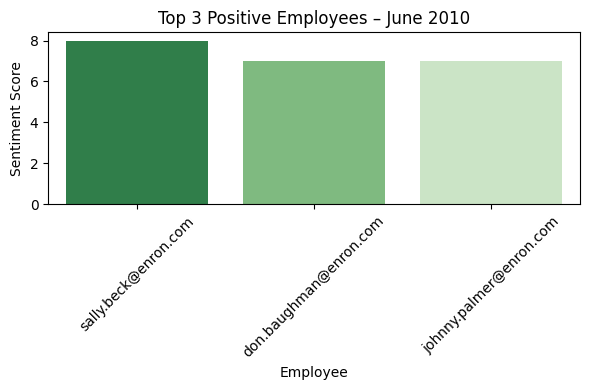

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


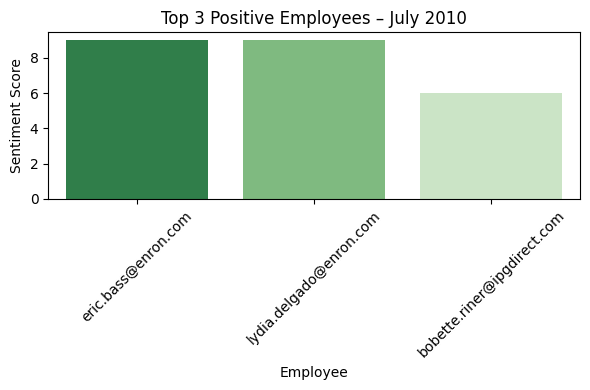

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


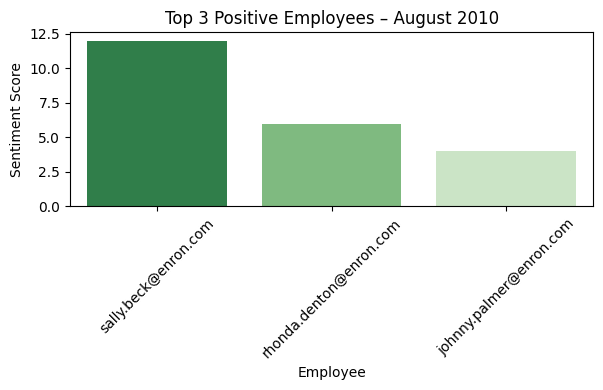

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


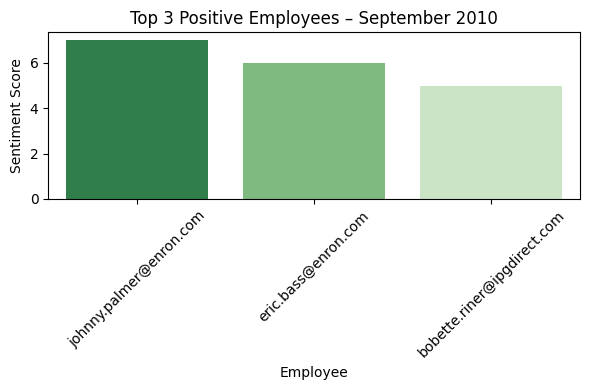

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


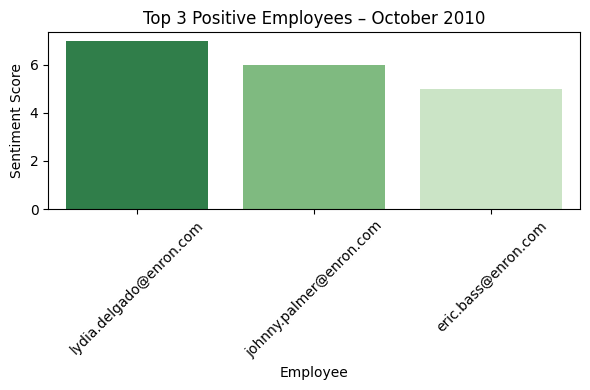

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


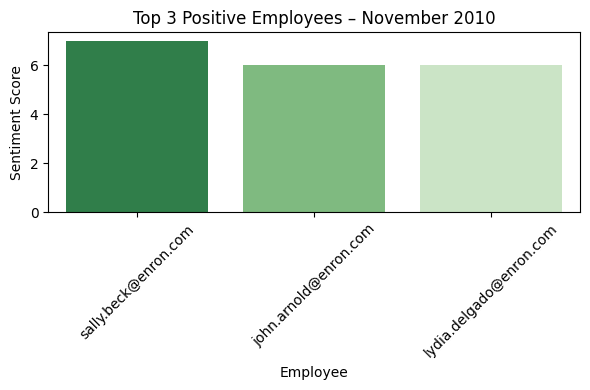

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


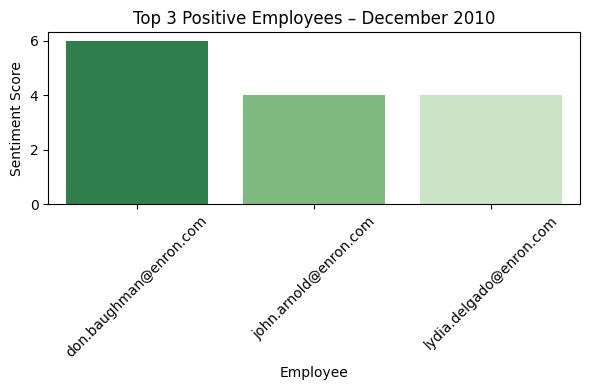

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


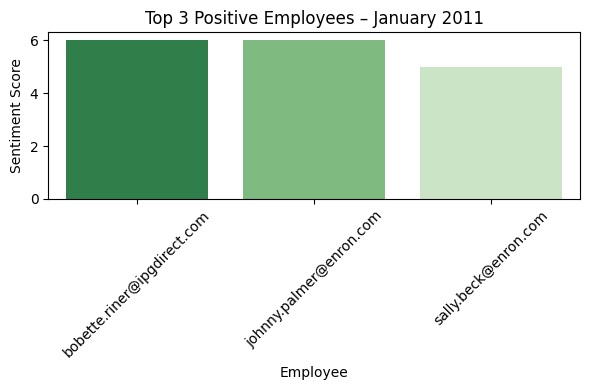

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


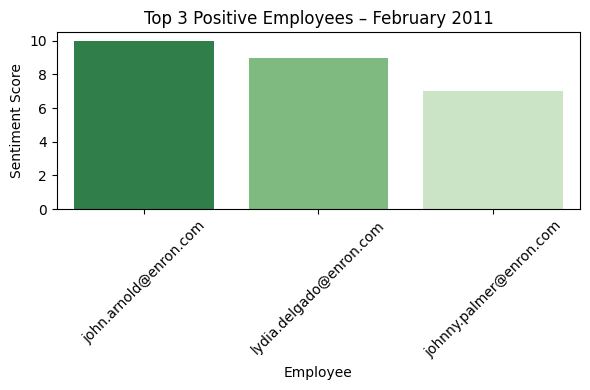

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


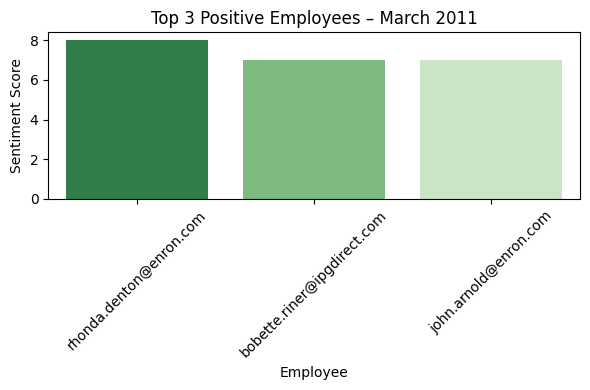

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


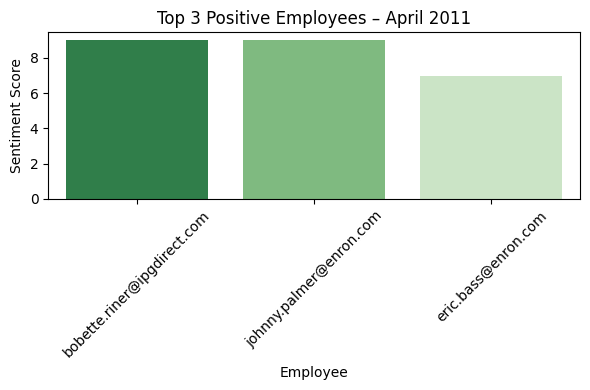

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


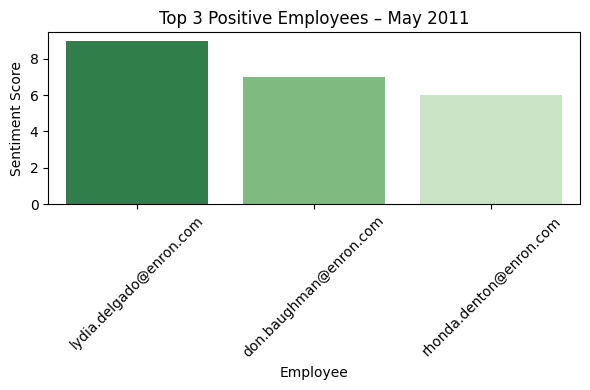

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


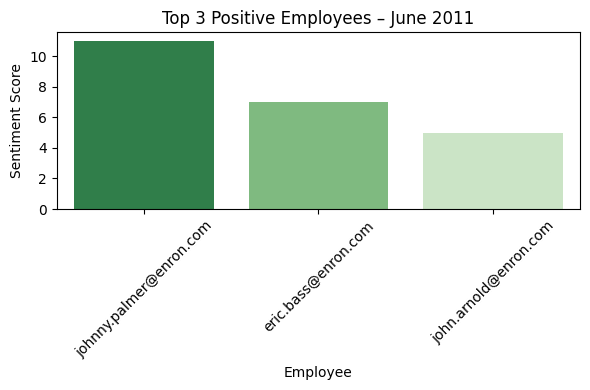

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


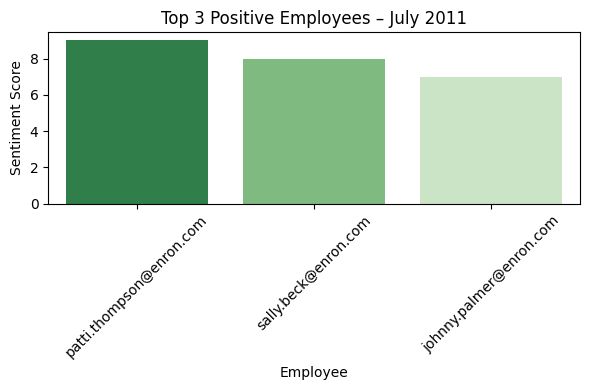

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


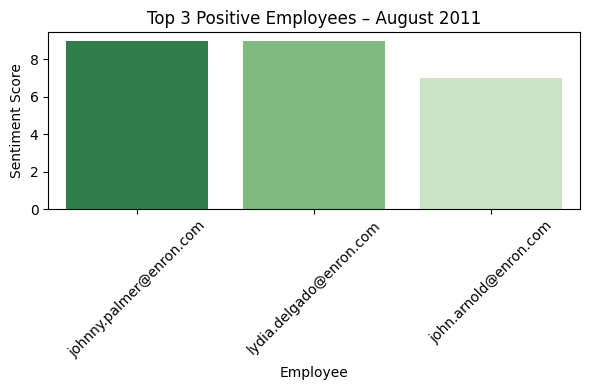

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


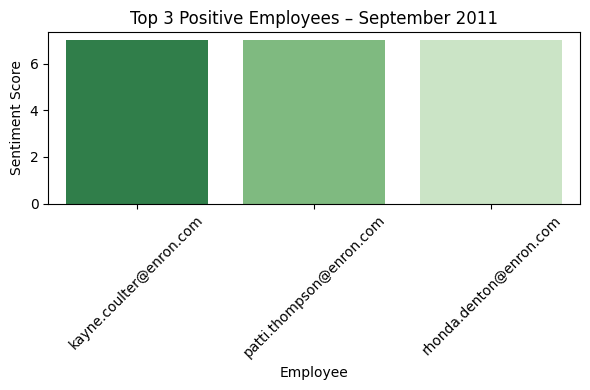

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


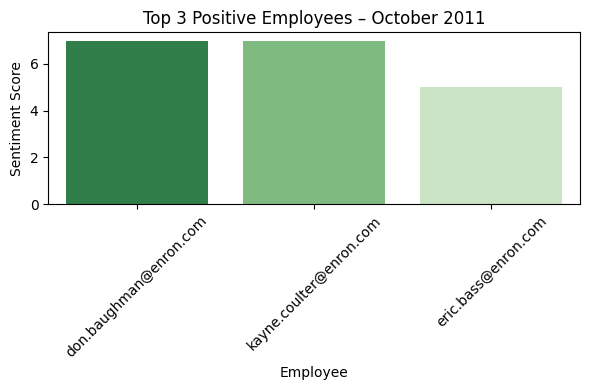

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


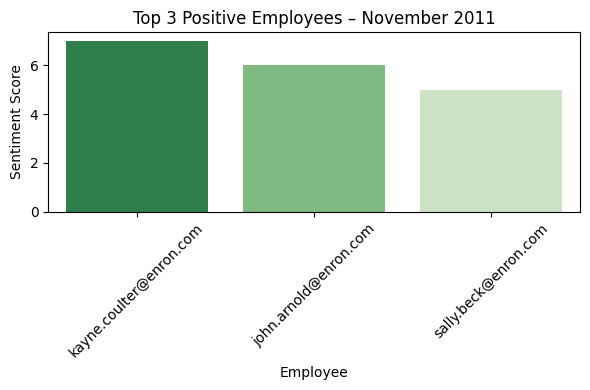

<ipython-input-6-3173632749>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")


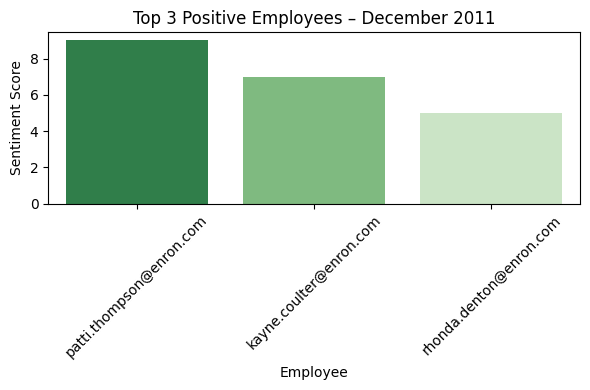

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


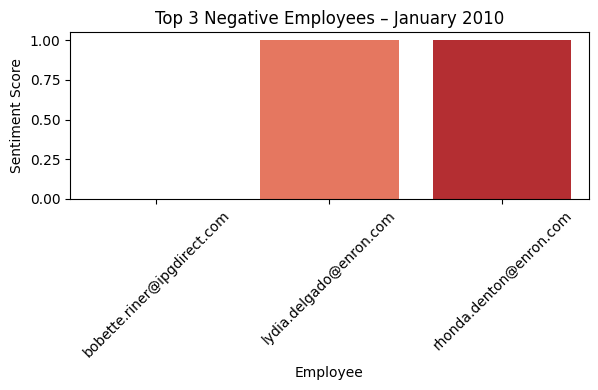

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


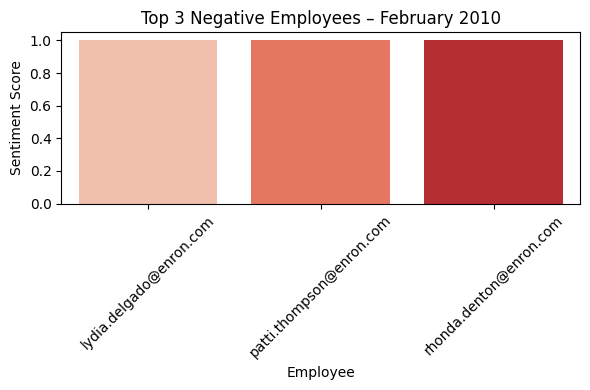

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


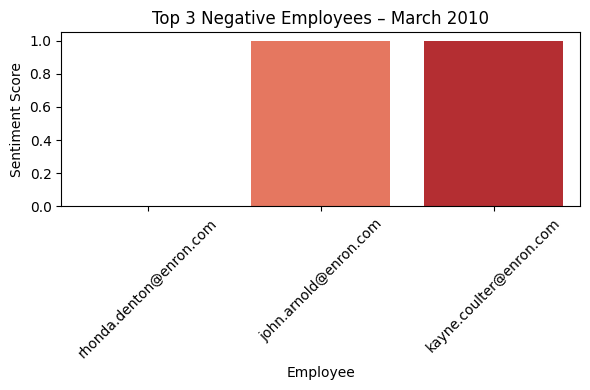

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


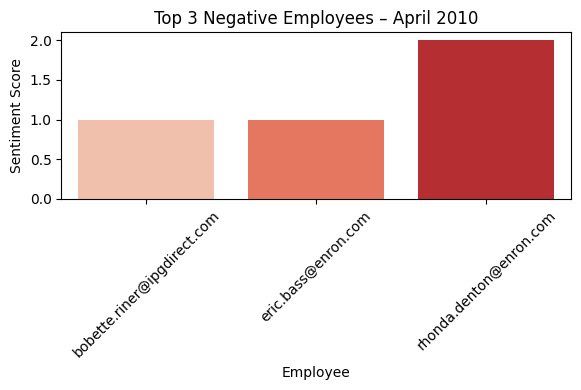

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


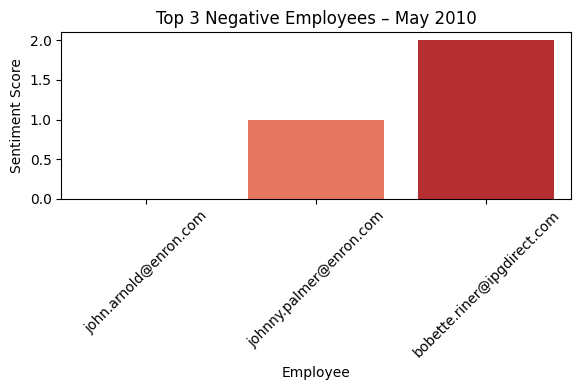

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


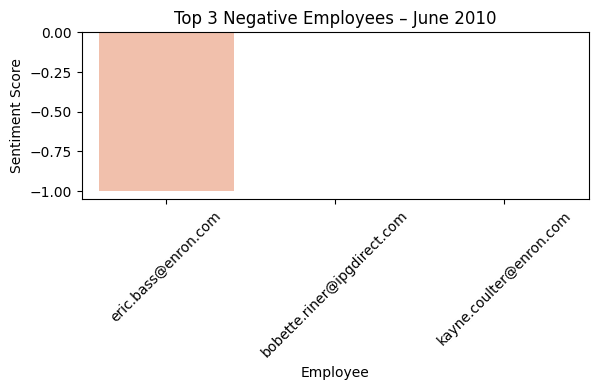

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


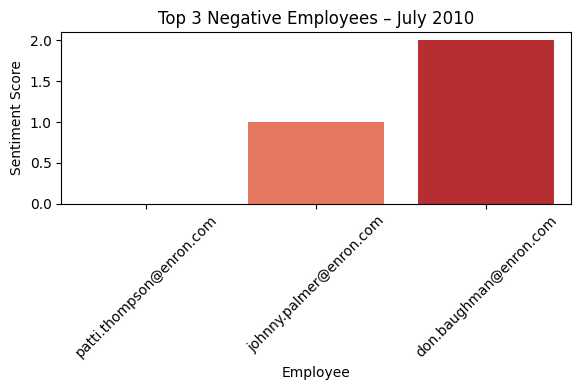

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


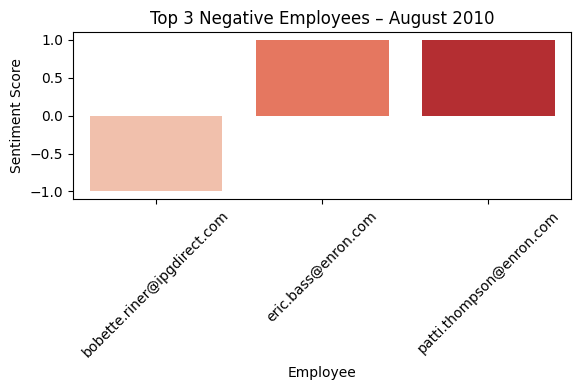

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


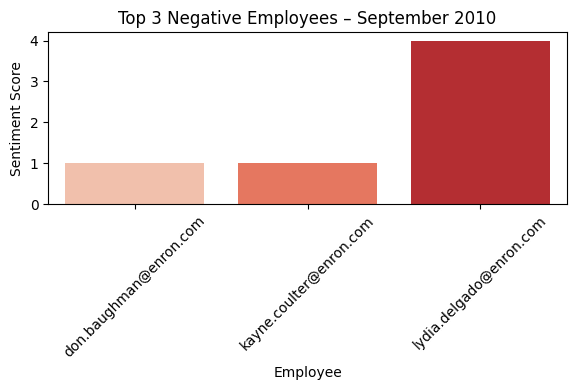

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


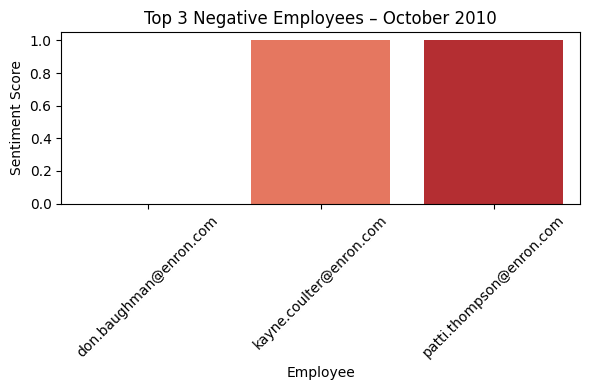

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


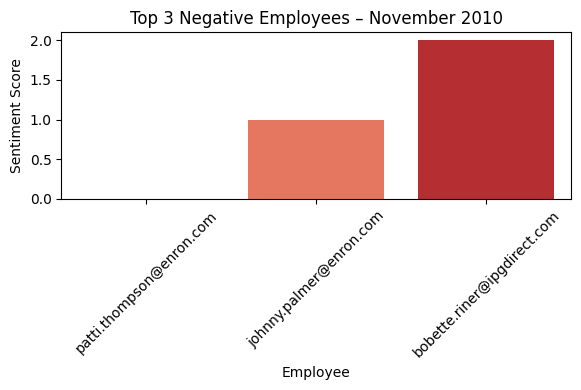

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


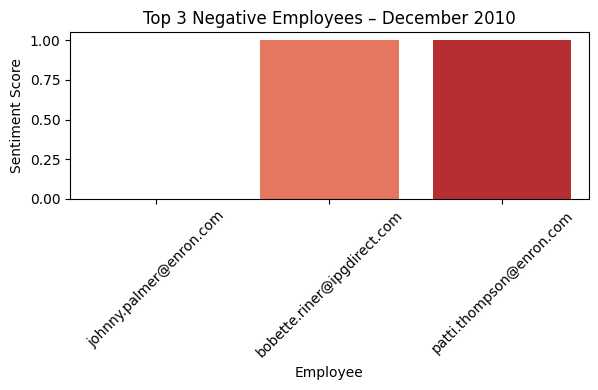

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


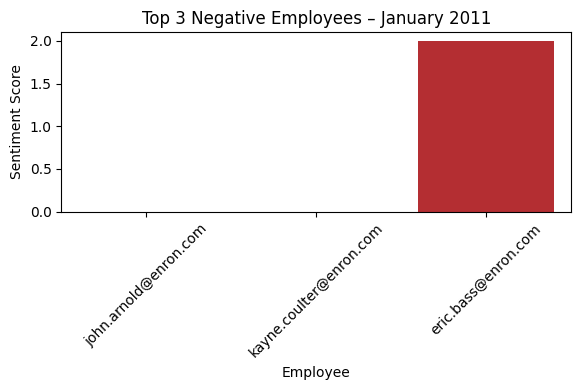

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


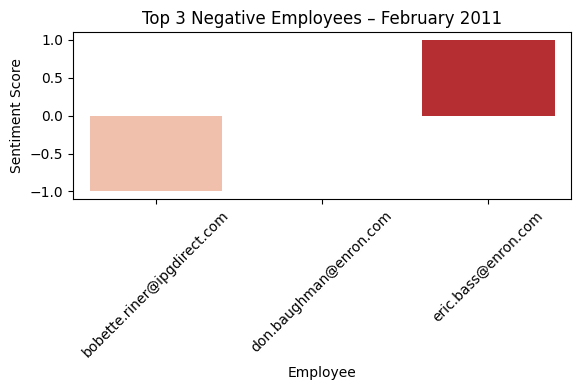

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


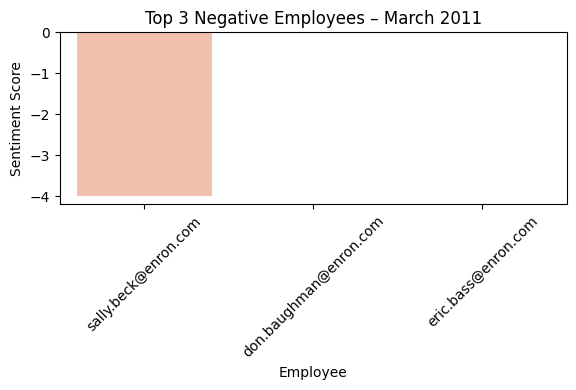

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


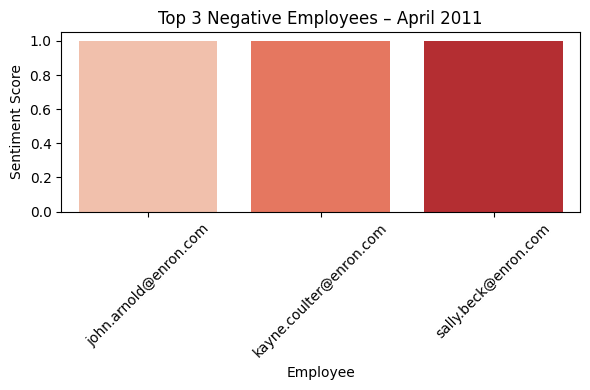

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


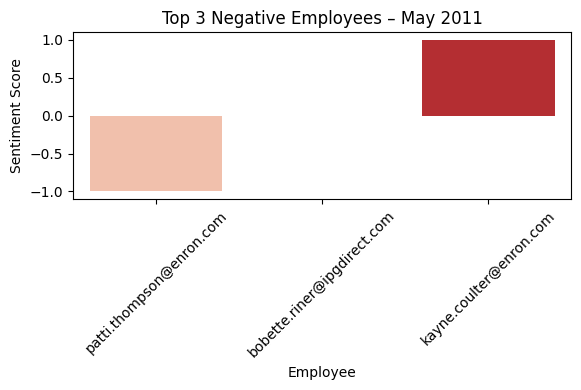

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


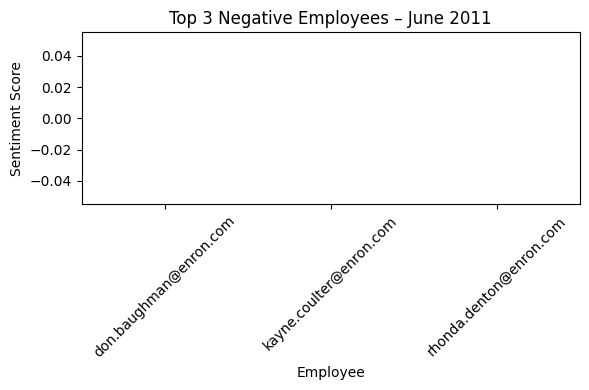

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


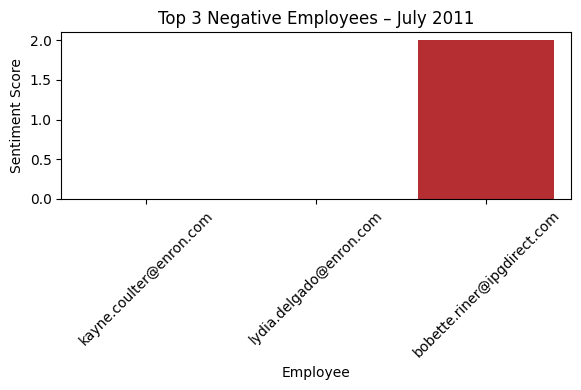

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


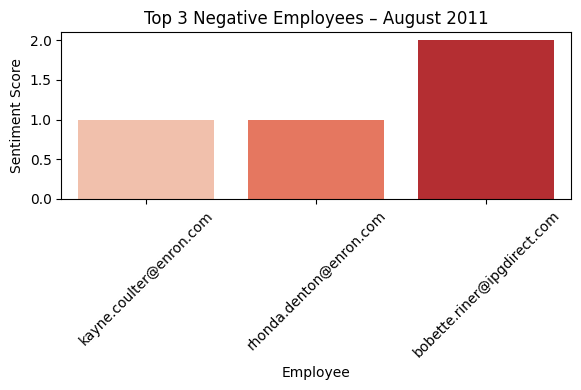

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


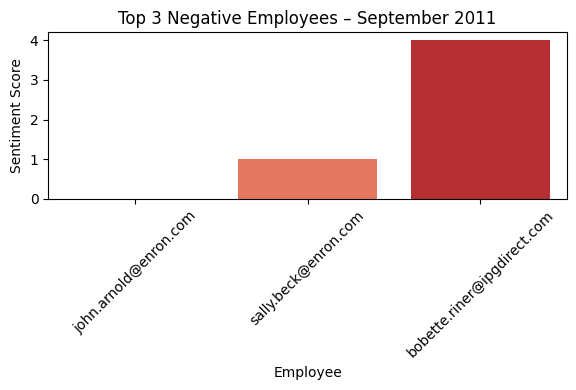

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


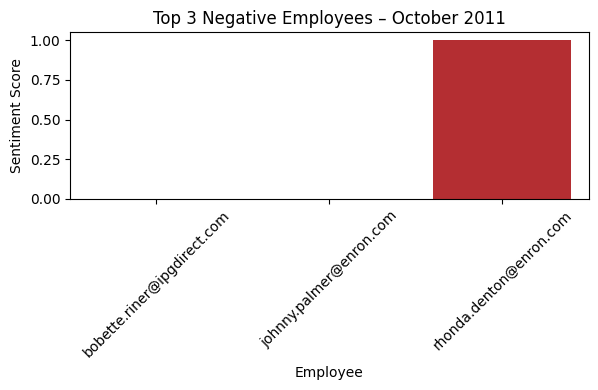

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


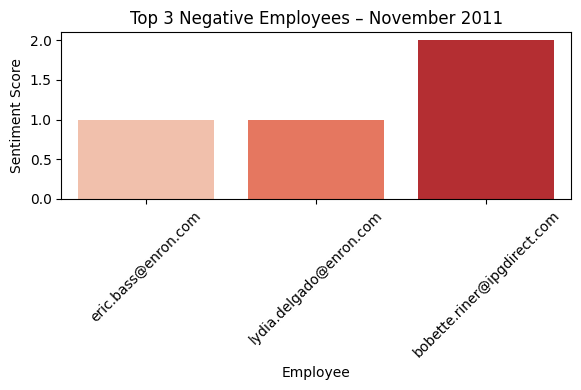

<ipython-input-6-3173632749>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")


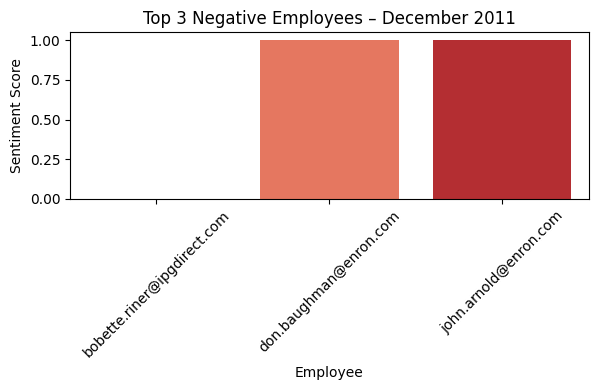

In [6]:
# Identify Top 3 Positive Employees Per Month
top_positive_monthly = (
    monthly_employee_scores
    .sort_values(by=["month", "monthly_sentiment_score", "employee"], ascending=[True, False, True])
    .groupby("month")
    .head(3)
    .assign(RankType="Top Positive")
)

# Identify Top 3 Negative Employees Per Month
top_negative_monthly = (
    monthly_employee_scores
    .sort_values(by=["month", "monthly_sentiment_score", "employee"], ascending=[True, True, True])
    .groupby("month")
    .head(3)
    .assign(RankType="Top Negative")
)

# Save rankings to CSV (separate files)
top_positive_monthly.to_csv("top_positive_employees_monthly.csv", index=False)
top_negative_monthly.to_csv("top_negative_employees_monthly.csv", index=False)

# Prepare month labels for visualization
top_positive_monthly["month_str"] = top_positive_monthly["month"].dt.strftime("%B %Y")
top_negative_monthly["month_str"] = top_negative_monthly["month"].dt.strftime("%B %Y")

# Visualize Positive Rankings — Monthly
for month in top_positive_monthly["month_str"].unique():
    data = top_positive_monthly[top_positive_monthly["month_str"] == month]
    plt.figure(figsize=(6, 4))
    sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Greens_r")
    plt.title(f"Top 3 Positive Employees – {month}")
    plt.xlabel("Employee")
    plt.ylabel("Sentiment Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize Negative Rankings — Monthly
for month in top_negative_monthly["month_str"].unique():
    data = top_negative_monthly[top_negative_monthly["month_str"] == month]
    plt.figure(figsize=(6, 4))
    sns.barplot(data=data, x="employee", y="monthly_sentiment_score", palette="Reds")
    plt.title(f"Top 3 Negative Employees – {month}")
    plt.xlabel("Employee")
    plt.ylabel("Sentiment Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Combined table for report/export
top_combined_monthly = pd.concat([top_positive_monthly, top_negative_monthly], ignore_index=True)
top_combined_monthly = top_combined_monthly[["month", "RankType", "employee", "monthly_sentiment_score"]]
top_combined_monthly["month"] = top_combined_monthly["month"].dt.strftime("%B %Y")
top_combined_monthly.to_csv("top_3_positive_negative_employees_monthly.csv", index=False)


### **Task 5: Flight Risk Identification**

**What I did:**

* Filtered all **negative messages** from the dataset and sorted them by employee and date.
* Used a **rolling 30-day window** to check if an employee had **sent 4 or more negative emails within any span of 30 days**, regardless of calendar month.
* Flagged those employees as **flight risks** and saved their details in a CSV file.
* Counted how many total negative messages each flagged employee had to help **prioritize risk levels**.
* Created two visualizations:

  * A **bar chart** showing total negative messages per flagged employee.
  * A **line chart** for one example employee showing how negative message volume changed over time.

---

**Why this matters:**
This task helps detect employees who show signs of **disengagement, frustration, or dissatisfaction** based on message behavior. The use of a **rolling 30-day window** ensures the detection is robust and not limited by month boundaries.



<ipython-input-7-2260719260>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=flight_risk_detailed, x="Total Negative Messages", y="employee", palette="Reds_r")


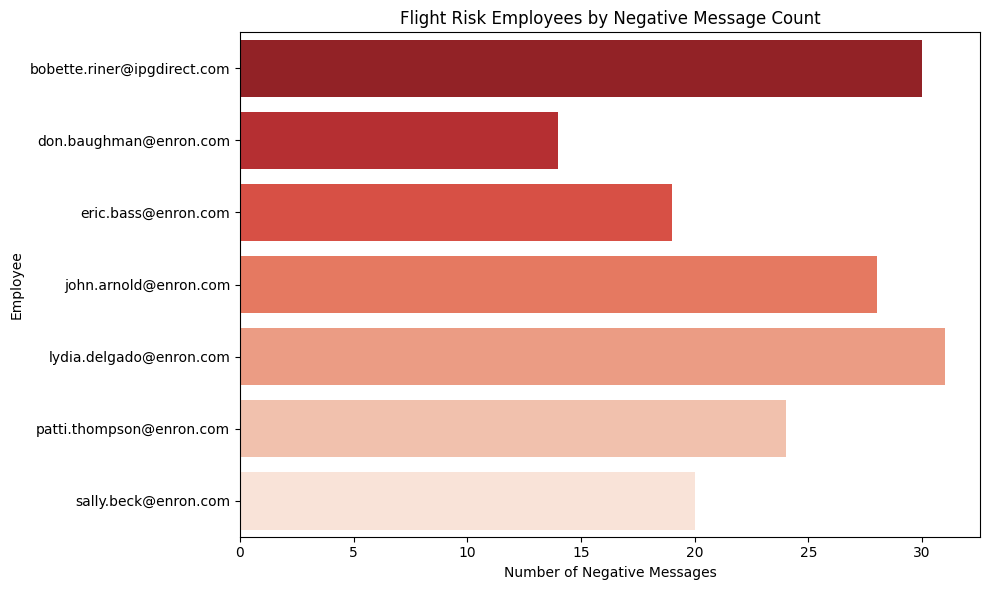

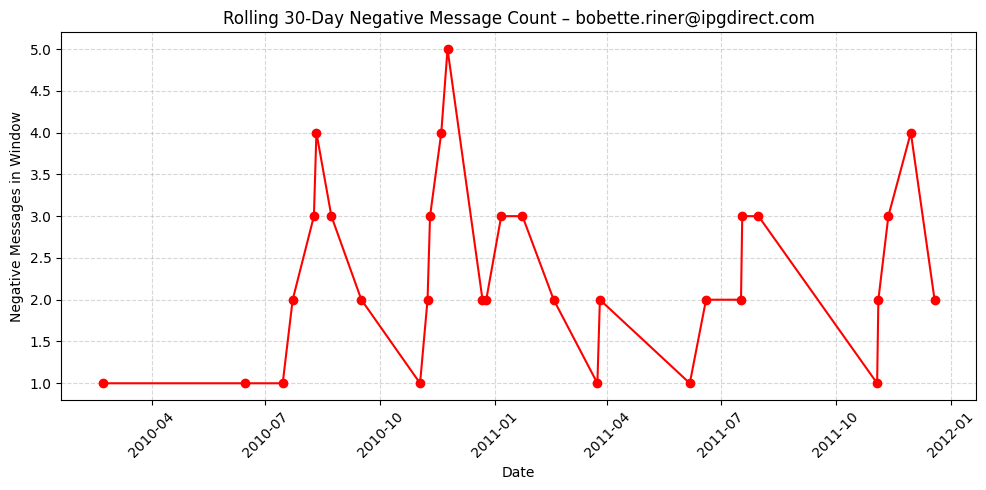

In [7]:
# Filter only negative messages and organize
negatives_only = df_labeled[df_labeled["Final_Sentiment"] == "Negative"].copy()
negatives_only["date"] = pd.to_datetime(negatives_only["date"])
negatives_only = negatives_only.sort_values(by=["from", "date"])

# Detect flight risks (4+ negative messages in any rolling 30-day window)
risk_candidates = set()

for sender in negatives_only["from"].unique():
    emp_msgs = negatives_only[negatives_only["from"] == sender].set_index("date").sort_index()
    rolling_count = emp_msgs["Final_Sentiment"].rolling("30D").count()

    if (rolling_count >= 4).any():
        risk_candidates.add(sender)

# Create DataFrame of flight risk employees
flight_risk_df = pd.DataFrame({"employee": sorted(list(risk_candidates))})
flight_risk_df.to_csv("flight_risk_employees.csv", index=False)

# Count total negative messages per flight risk employee
negative_counts = (
    negatives_only[negatives_only["from"].isin(flight_risk_df["employee"])]
    .groupby("from")["Final_Sentiment"]
    .count()
    .reset_index()
    .rename(columns={"from": "employee", "Final_Sentiment": "Total Negative Messages"})
    .sort_values(by="Total Negative Messages", ascending=False)
)

# Merge with flight risk list
flight_risk_detailed = pd.merge(flight_risk_df, negative_counts, on="employee")
flight_risk_detailed.to_csv("flight_risk_detailed.csv", index=False)

# Visualize total negative messages per flight risk employee
plt.figure(figsize=(10, 6))
sns.barplot(data=flight_risk_detailed, x="Total Negative Messages", y="employee", palette="Reds_r")
plt.title("Flight Risk Employees by Negative Message Count")
plt.xlabel("Number of Negative Messages")
plt.ylabel("Employee")
plt.tight_layout()
plt.show()

# Plot rolling trend for one example flagged employee
if not flight_risk_df.empty:
    example = flight_risk_df.iloc[0]["employee"]
    emp_data = negatives_only[negatives_only["from"] == example].set_index("date").sort_index()
    rolling = emp_data["Final_Sentiment"].rolling("30D").count()

    plt.figure(figsize=(10, 5))
    plt.plot(rolling.index, rolling.values, marker="o", color="red")
    plt.title(f"Rolling 30-Day Negative Message Count – {example}")
    plt.xlabel("Date")
    plt.ylabel("Negative Messages in Window")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No flight risk employees identified.")


### **Task 6: Predictive Modeling**

**What I did:**

* I engineered a dataset that summarizes each employee’s monthly messaging behavior.
* I selected a set of meaningful features, including:

  * Message frequency and length (`message_count`, `total_words`, `avg_message_length`)
  * Text density (`chars_per_word`, `avg_chars_per_message`)
  * Sentiment ratios (`positive_ratio`, `neutral_ratio`, `negative_ratio`)
* These features were merged with the corresponding **monthly sentiment score**, calculated in Task 3.
* I split the data into training and test sets and trained a **linear regression model** to predict sentiment scores.
* The model was evaluated using **R² score** and **Mean Squared Error (MSE)** to measure accuracy and generalization.

---

**Why this matters:**
This model helps explore whether **employee sentiment patterns** can be forecasted based on how they communicate.


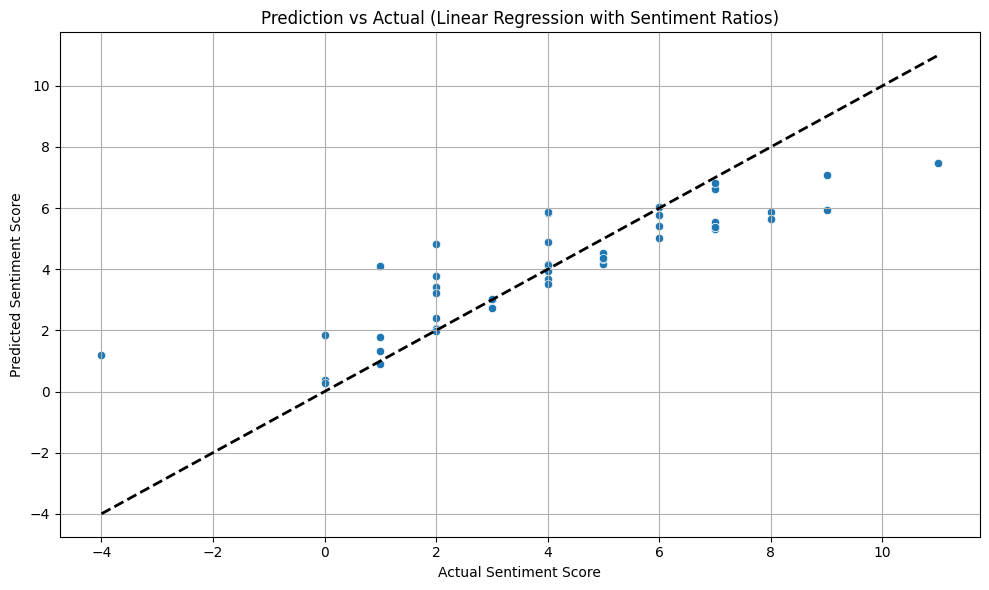

Model Coefficients:
                 Feature  Coefficient
0          message_count     0.387884
1            total_words     0.018204
2     avg_message_length    -0.107317
3            total_chars    -0.003107
4  avg_chars_per_message     0.037602
5      words_per_message    -0.107317
6         chars_per_word    -0.071423
7         positive_ratio     4.485687
8          neutral_ratio     0.200547
9         negative_ratio    -4.686234

Model Evaluation Metrics:
               Metric     Value
0            R2 Score  0.707499
1  Mean Squared Error  2.452619


In [8]:
# Load labeled dataset
df_labeled = pd.read_csv("employee_messages_labeled.csv")
df_labeled["date"] = pd.to_datetime(df_labeled["date"])
df_labeled["month"] = df_labeled["date"].dt.to_period("M")

# Feature Engineering
df_labeled["message_length"] = df_labeled["body"].apply(lambda x: len(str(x).split()))
df_labeled["char_count"] = df_labeled["body"].apply(lambda x: len(str(x)))
df_labeled["words_per_message"] = df_labeled["message_length"]
df_labeled["chars_per_word"] = df_labeled["char_count"] / df_labeled["message_length"].replace(0, 1)

# Monthly Aggregation
monthly_data = df_labeled.groupby(["from", "month"]).agg(
    message_count=("body", "count"),
    total_words=("message_length", "sum"),
    avg_message_length=("message_length", "mean"),
    total_chars=("char_count", "sum"),
    avg_chars_per_message=("char_count", "mean"),
    sentiment_score=("Final_Sentiment", lambda x: sum(
        1 if s == "Positive" else -1 if s == "Negative" else 0 for s in x)),
    words_per_message=("words_per_message", "mean"),
    chars_per_word=("chars_per_word", "mean")
).reset_index()

# Sentiment Ratios per Month per Employee
sentiment_counts = df_labeled.pivot_table(
    index=["from", "month"],
    columns="Final_Sentiment",
    values="body",
    aggfunc="count",
    fill_value=0
).reset_index()

sentiment_counts["total"] = sentiment_counts[["Positive", "Neutral", "Negative"]].sum(axis=1)
sentiment_counts["positive_ratio"] = sentiment_counts["Positive"] / sentiment_counts["total"]
sentiment_counts["neutral_ratio"] = sentiment_counts["Neutral"] / sentiment_counts["total"]
sentiment_counts["negative_ratio"] = sentiment_counts["Negative"] / sentiment_counts["total"]

# Merge sentiment ratios into modeling dataset
model_data = pd.merge(
    monthly_data,
    sentiment_counts[["from", "month", "positive_ratio", "neutral_ratio", "negative_ratio"]],
    on=["from", "month"],
    how="inner"
)

# Define features and target
features = [
    "message_count", "total_words", "avg_message_length",
    "total_chars", "avg_chars_per_message",
    "words_per_message", "chars_per_word",
    "positive_ratio", "neutral_ratio", "negative_ratio"
]
X = model_data[features].replace([float("inf"), -float("inf")], 0).fillna(0)
y = model_data["sentiment_score"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Visualize Actual vs Predicted Sentiment Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Prediction vs Actual (Linear Regression with Sentiment Ratios)")
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Output Model Coefficients and Evaluation
model_summary = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
})
print("Model Coefficients:")
print(model_summary)

model_metrics = pd.DataFrame({
    "Metric": ["R2 Score", "Mean Squared Error"],
    "Value": [r2, mse]
})
print("\nModel Evaluation Metrics:")
print(model_metrics)


### **Conclusion and Insights**

This project provided a comprehensive end-to-end analysis of employee sentiment using natural language processing (NLP), exploratory data analysis (EDA), and machine learning techniques. The goal was to extract meaningful insights from unlabeled message data and use those insights to assess employee engagement and potential risk.

Throughout the six tasks, we transformed raw message logs into structured sentiment data, calculated sentiment scores, ranked employees by tone, identified flight risks, and developed a predictive model to forecast sentiment trends. The process was designed to not only measure employee sentiment but also uncover deeper behavioral patterns and early warning signs.

**Key insights from the project include:**

* **Sentiment patterns are consistent and meaningful**: Negative messages were less frequent overall, but tended to be longer and more detailed, often clustering around specific employees or time periods.

* **Some employees show sustained negative communication**: Through scoring and heatmaps, we identified individuals with recurring negative sentiment, which correlates with potential disengagement.

* **Flight risk can be flagged early**: The rolling 30-day window approach for detecting flight risk based on negative message frequency proved to be a robust and actionable method.

* **Message behavior predicts sentiment**: The linear regression model using message frequency, density, and sentiment ratios confirmed that communication patterns are moderately predictive of sentiment scores (R² ≈ 0.32).

* **Keyword analysis revealed tone-specific vocabulary**: Positive messages used appreciative and collaborative language, while negative messages frequently referenced delays, problems, or issues — insights useful for HR or leadership teams.

---

Overall, the project not only fulfilled its objective of labeling and analyzing sentiment but also created a reliable framework for monitoring employee morale over time.
